In [7]:
import numpy as np
import pandas as pd
import queue
import matplotlib.pyplot as plt

from Backtest.backtest import Backtest
from Backtest.data import OHLCDataHandler
from MACD_BOLLStrategy import MACD_BOLLStrategy
from Backtest.open_json_gz_files import open_json_gz_files
from Backtest.generate_bars import generate_bars

In [8]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

In [9]:
def run_backtest(config, trading_data, ohlc_data, short_window, delta_window, window, a):
    short_window = int(short_window)
    long_window = short_window + int(delta_window)
    window = int(window)
    config['title'] = "MACD_BOLLStrategy" + "_" +  str(short_window) + "_" + str(long_window) + "_" + str(window) + "_" + str(a)
    print("---------------------------------")
    print(config['title'])
    print("---------------------------------")
    
    events_queue = queue.Queue()

    data_handler = OHLCDataHandler(
        config, events_queue,
        trading_data = trading_data, ohlc_data = ohlc_data
    )
    strategy = MACD_BOLLStrategy(config, events_queue, data_handler,
                            short_window=short_window, long_window=long_window,
                            window = window, a = a)

    backtest = Backtest(config, events_queue, strategy,
                        data_handler= data_handler)

    results = backtest.start_trading()
    
    # dict_ans = {
    #     "short_window": [short_window],
    #     "long_window": [long_window],
    #     "Sharpe Ratio": [results['sharpe']],
    #     "Total Returns": [(results['cum_returns'][-1] - 1)],
    #     "Max Drawdown": [(results["max_drawdown"] * 100.0)],
    #     "Max Drawdown Duration": [(results['max_drawdown_duration'])],
    #     "Trades": [results['trade_info']['trading_num']],
    #     "Trade Winning": [results['trade_info']['win_pct']],
    #     "Average Trade": [results['trade_info']['avg_trd_pct']],
    #     "Average Win": [results['trade_info']['avg_win_pct']],
    #     "Average Loss": [results['trade_info']['avg_loss_pct']],
    #     "Best Trade": [results['trade_info']['max_win_pct']],
    #     "Worst Trade": [results['trade_info']['max_loss_pct']],
    #     "Worst Trade Date": [results['trade_info']['max_loss_dt']],
    #     "Avg Days in Trade": [results['trade_info']['avg_dit']]
    # }
    # return pd.DataFrame(dict_ans)
    return -1 * (results['cum_returns'][-1] - 1)

In [10]:
def f(params):
    config = {
        "csv_dir": "C:/backtest/Binance",
        "out_dir": "C:/backtest/results/MACD_BOLLStrategy",
        "title": "MACD_BOLLStrategy",
        "is_plot": False,
        "save_plot": False,
        "save_tradelog": False,
        "start_date": pd.Timestamp("2017-07-01T00:0:00", freq = "60" + "T"),    # str(freq) + "T"
        "end_date": pd.Timestamp("2018-04-01T00:00:00", freq = "60" + "T"),
        "equity": 1.0,
        "freq": 60,      # min
        "commission_ratio": 0.001,
        "suggested_quantity": None,     # None or a value
        "max_quantity": None,           # None or a value, Maximum purchase quantity
        "min_quantity": None,           # None or a value, Minimum purchase quantity
        "min_handheld_cash": None,      # None or a value, Minimum handheld funds
        "exchange": "Binance",
        "tickers": ['BTCUSDT']
    }
    # trading_data = {}
    # for ticker in config['tickers']:
    #     # trading_data[ticker] = open_gz_files(config['csv_dir'], ticker)
    #     trading_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker + '.h5', key=ticker)

    ohlc_data = {}
    for ticker in config['tickers']:
        # ohlc_data[ticker] = generate_bars(trading_data, ticker, config['freq'])
        ohlc_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker + '_OHLC_60min.h5', key=ticker)

    trading_data = None
    
    short_window = params['short_window']
    delta_window = params['delta_window']
    window = params['window']
    a = params['a']
    val = run_backtest(config, trading_data, ohlc_data, short_window, delta_window, window, a)
    return {'loss': val, 'status': STATUS_OK}

In [11]:
space = {
    'short_window': hp.randint('short_window', 120),
    'delta_window': hp.randint('delta_window', 120),
    'window': hp.randint('window', 240),
    'a': hp.uniform('a', 0.1, 3)
}

In [12]:
# print(hyperopt.pyll.stochastic.sample(space))

In [13]:
trials = Trials()

In [14]:
best = fmin(fn=f, space=space, algo=tpe.suggest, max_evals=250, trials=trials)

---------------------------------
MACD_BOLLStrategy2_48_150_118_0.48425029354827553
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.4013533301
Sortino Ratio: 1.6565104089
Max Drawdown: 0.5255746957
Max Drawdown Duration: 273500
Total Returns: 0.4385160450
Annualized Returns: 1.0320796760
Compound Annual Growth Rate: 1.3532271665
---------------------------------
Trades: 16
Trade Winning: 43.75%
Average Trade: 3.21%
Average Win: 15.03%
Average Loss: -5.97%
Best Trade: 24.97%
Worst Trade: -17.81%
Worst Trade Date: 1 days 14:00:00
Avg Days in Trade: 4 days 15:18:45
---------------------------------
---------------------------------
MACD_BOLLStrategy2_105_200_116_0.7461370489501851
---------------------------------
Data

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.1312870658
Sortino Ratio: 1.3342405937
Max Drawdown: 0.4767583823
Max Drawdown Duration: 273500
Total Returns: 0.2892404919
Annualized Returns: 0.6807487128
Compound Annual Growth Rate: 0.8183564186
---------------------------------
Trades: 14
Trade Winning: 50.00%
Average Trade: 2.48%
Average Win: 10.77%
Average Loss: -5.80%
Best Trade: 17.67%
Worst Trade: -11.93%
Worst Trade Date: 1 days 05:00:00
Avg Days in Trade: 4 days 21:12:51
---------------------------------
---------------------------------
MACD_BOLLStrategy2_3_27_198_0.23093834435066468
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.6087746980
Sortino Ra

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000000000
Max Drawdown Duration: 0
Total Returns: 0.0000000000
Annualized Returns: 0.0000000000
Compound Annual Growth Rate: 0.0000000000
---------------------------------
Trades: 0
Trade Winning: nan%
Average Trade: nan%
Average Win: nan%
Average Loss: nan%
Best Trade: nan%
Worst Trade: nan%
Worst Trade Date: 0
Avg Days in Trade: 0
---------------------------------
---------------------------------
MACD_BOLLStrategy2_75_90_186_1.143921382254002
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.9270445832
Sortino Ratio: 2.3322258211
Max Drawdown: 0.4430033501
Max Drawdown Duratio

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.6361371749
Sortino Ratio: 2.1124783422
Max Drawdown: 0.5239003409
Max Drawdown Duration: 273500
Total Returns: 0.5705148493
Annualized Returns: 1.3427485437
Compound Annual Growth Rate: 1.8933391056
---------------------------------
Trades: 15
Trade Winning: 53.33%
Average Trade: 4.07%
Average Win: 13.96%
Average Loss: -7.23%
Best Trade: 28.54%
Worst Trade: -17.04%
Worst Trade Date: 0 days 23:00:00
Avg Days in Trade: 4 days 21:48:00
---------------------------------
---------------------------------
MACD_BOLLStrategy2_36_57_64_0.7133603100089942
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.4126287506
Sortino Rat

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.2330605308
Sortino Ratio: 3.1326161845
Max Drawdown: 0.3485447990
Max Drawdown Duration: 273500
Total Returns: 0.7586927549
Annualized Returns: 1.7856390471
Compound Annual Growth Rate: 2.7763530456
---------------------------------
Trades: 11
Trade Winning: 72.73%
Average Trade: 5.97%
Average Win: 10.71%
Average Loss: -6.66%
Best Trade: 19.63%
Worst Trade: -9.43%
Worst Trade Date: 1 days 23:00:00
Avg Days in Trade: 5 days 04:38:11
---------------------------------
---------------------------------
MACD_BOLLStrategy2_79_198_155_1.6493996751423352
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.1924830684
Sortino Ra

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.3013432282
Sortino Ratio: 2.8184599367
Max Drawdown: 0.2951367324
Max Drawdown Duration: 250900
Total Returns: 0.8897628237
Annualized Returns: 2.0941220675
Compound Annual Growth Rate: 3.4724434389
---------------------------------
Trades: 6
Trade Winning: 50.00%
Average Trade: 16.41%
Average Win: 39.96%
Average Loss: -7.15%
Best Trade: 102.28%
Worst Trade: -9.50%
Worst Trade Date: 3 days 14:00:00
Avg Days in Trade: 10 days 20:10:00
---------------------------------
---------------------------------
MACD_BOLLStrategy2_27_71_15_0.1325751285919835
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.5347526691
Sortino Ra

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.9210946366
Sortino Ratio: 3.2630691415
Max Drawdown: 0.3379618241
Max Drawdown Duration: 227600
Total Returns: 0.6547357525
Annualized Returns: 1.5409686168
Compound Annual Growth Rate: 2.2718540462
---------------------------------
Trades: 31
Trade Winning: 51.61%
Average Trade: 2.15%
Average Win: 8.16%
Average Loss: -4.27%
Best Trade: 28.82%
Worst Trade: -7.23%
Worst Trade Date: 1 days 02:00:00
Avg Days in Trade: 2 days 00:13:33
---------------------------------
---------------------------------
MACD_BOLLStrategy2_86_167_58_2.5164134093247554
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.5628943650
Sortino Rati

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.6747062988
Sortino Ratio: 2.1174321807
Max Drawdown: 0.4785801456
Max Drawdown Duration: 273500
Total Returns: 0.5291881321
Annualized Returns: 1.2454830835
Compound Annual Growth Rate: 1.7173294914
---------------------------------
Trades: 13
Trade Winning: 53.85%
Average Trade: 4.13%
Average Win: 12.63%
Average Loss: -5.80%
Best Trade: 21.83%
Worst Trade: -13.46%
Worst Trade Date: 2 days 06:00:00
Avg Days in Trade: 5 days 08:32:18
---------------------------------
---------------------------------
MACD_BOLLStrategy2_91_118_66_0.18011199053550275
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.5564443276
Sortino R

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.7974468509
Sortino Ratio: 4.5923465109
Max Drawdown: 0.2751280854
Max Drawdown Duration: 250900
Total Returns: 1.1472116633
Annualized Returns: 2.7000467950
Compound Annual Growth Rate: 5.0407633092
---------------------------------
Trades: 24
Trade Winning: 50.00%
Average Trade: 3.96%
Average Win: 10.72%
Average Loss: -2.80%
Best Trade: 47.23%
Worst Trade: -9.38%
Worst Trade Date: 0 days 22:00:00
Avg Days in Trade: 2 days 09:05:00
---------------------------------
---------------------------------
MACD_BOLLStrategy2_5_38_36_2.7878687086837814
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.7483975012
Sortino Ratio

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.2614053311
Sortino Ratio: 1.9601584096
Max Drawdown: 0.2826358805
Max Drawdown Duration: 227600
Total Returns: 0.3590466534
Annualized Returns: 0.8450426340
Compound Annual Growth Rate: 1.0586231466
---------------------------------
Trades: 51
Trade Winning: 37.25%
Average Trade: 1.02%
Average Win: 6.79%
Average Loss: -2.41%
Best Trade: 32.00%
Worst Trade: -9.73%
Worst Trade Date: 0 days 09:00:00
Avg Days in Trade: 1 days 06:16:28
---------------------------------
---------------------------------
MACD_BOLLStrategy2_47_165_1_0.5359543709591328
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: nan
Sortino Ratio: nan
Max

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.0480893099
Sortino Ratio: 2.1551191471
Max Drawdown: 0.3758755449
Max Drawdown Duration: 250900
Total Returns: 0.2445690368
Annualized Returns: 0.5756111667
Compound Annual Growth Rate: 0.6735325640
---------------------------------
Trades: 64
Trade Winning: 31.25%
Average Trade: 0.75%
Average Win: 7.82%
Average Loss: -2.47%
Best Trade: 34.21%
Worst Trade: -5.98%
Worst Trade Date: 0 days 06:00:00
Avg Days in Trade: 0 days 17:10:19
---------------------------------
---------------------------------
MACD_BOLLStrategy2_61_175_180_0.10100020826416989
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.6270922743
Sortino Ra

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.6109156580
Sortino Ratio: 3.0101320521
Max Drawdown: 0.3331462709
Max Drawdown Duration: 250900
Total Returns: 0.4872578378
Annualized Returns: 1.1467970606
Compound Annual Growth Rate: 1.5452105922
---------------------------------
Trades: 59
Trade Winning: 44.07%
Average Trade: 1.06%
Average Win: 5.88%
Average Loss: -2.74%
Best Trade: 30.83%
Worst Trade: -6.70%
Worst Trade Date: 0 days 03:00:00
Avg Days in Trade: 0 days 19:06:06
---------------------------------
---------------------------------
MACD_BOLLStrategy2_58_64_217_0.7144931356458684
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.1714585441
Sortino Rati

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.7528272786
Sortino Ratio: 2.5765905584
Max Drawdown: 0.3387131283
Max Drawdown Duration: 250900
Total Returns: 0.6139236415
Annualized Returns: 1.4449143201
Compound Annual Growth Rate: 2.0850900788
---------------------------------
Trades: 144
Trade Winning: 56.94%
Average Trade: 0.62%
Average Win: 2.81%
Average Loss: -2.28%
Best Trade: 26.37%
Worst Trade: -10.69%
Worst Trade Date: 0 days 06:00:00
Avg Days in Trade: 0 days 08:49:35
---------------------------------
---------------------------------
MACD_BOLLStrategy2_89_191_8_2.3438192571078447
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.5230041748
Sortino Rat

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.1186243347
Sortino Ratio: 3.1051433989
Max Drawdown: 0.3169597373
Max Drawdown Duration: 273500
Total Returns: 0.7891998321
Annualized Returns: 1.8574396907
Compound Annual Growth Rate: 2.9323406471
---------------------------------
Trades: 17
Trade Winning: 52.94%
Average Trade: 4.39%
Average Win: 13.70%
Average Loss: -6.09%
Best Trade: 34.57%
Worst Trade: -9.54%
Worst Trade Date: 0 days 03:00:00
Avg Days in Trade: 4 days 01:56:28
---------------------------------
---------------------------------
MACD_BOLLStrategy2_4_17_39_0.8987835200925666
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.3950692862
Sortino Ratio

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.0737499550
Sortino Ratio: 2.6031088273
Max Drawdown: 0.3884175217
Max Drawdown Duration: 273500
Total Returns: 0.7837381335
Annualized Returns: 1.8445851827
Compound Annual Growth Rate: 2.9041470877
---------------------------------
Trades: 20
Trade Winning: 45.00%
Average Trade: 3.85%
Average Win: 15.56%
Average Loss: -5.74%
Best Trade: 30.71%
Worst Trade: -11.70%
Worst Trade Date: 1 days 09:00:00
Avg Days in Trade: 3 days 11:51:00
---------------------------------
---------------------------------
MACD_BOLLStrategy2_105_156_182_2.9842125266049333
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.7404801473
Sortino 

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 3.3070550712
Sortino Ratio: 5.7989773211
Max Drawdown: 0.2121815996
Max Drawdown Duration: 170800
Total Returns: 1.2270875795
Annualized Returns: 2.8880406224
Compound Annual Growth Rate: 5.5830208639
---------------------------------
Trades: 17
Trade Winning: 47.06%
Average Trade: 5.73%
Average Win: 16.22%
Average Loss: -3.59%
Best Trade: 37.38%
Worst Trade: -7.55%
Worst Trade Date: 1 days 20:00:00
Avg Days in Trade: 2 days 21:03:32
---------------------------------
---------------------------------
MACD_BOLLStrategy2_68_92_234_0.6641930339633502
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.3851896702
Sortino Rat

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.0251245639
Sortino Ratio: 2.7731975868
Max Drawdown: 0.4269757181
Max Drawdown Duration: 273500
Total Returns: 0.6835610603
Annualized Returns: 1.6088110930
Compound Annual Growth Rate: 2.4075814403
---------------------------------
Trades: 12
Trade Winning: 58.33%
Average Trade: 5.29%
Average Win: 13.17%
Average Loss: -5.75%
Best Trade: 25.44%
Worst Trade: -14.53%
Worst Trade Date: 1 days 13:00:00
Avg Days in Trade: 5 days 10:55:00
---------------------------------
---------------------------------
MACD_BOLLStrategy2_66_68_100_0.607303473407853
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.9840889309
Sortino Rat

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.6245328707
Sortino Ratio: 0.7397044059
Max Drawdown: 0.5332476977
Max Drawdown Duration: 273500
Total Returns: 0.0824606730
Annualized Returns: 0.1940772422
Compound Annual Growth Rate: 0.2050122578
---------------------------------
Trades: 14
Trade Winning: 42.86%
Average Trade: 1.32%
Average Win: 12.17%
Average Loss: -6.81%
Best Trade: 17.67%
Worst Trade: -16.21%
Worst Trade Date: 2 days 04:00:00
Avg Days in Trade: 4 days 22:04:17
---------------------------------
---------------------------------
MACD_BOLLStrategy2_28_28_69_0.5532041365625825
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: nan
Sortino Ratio: nan
M

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.8320043904
Sortino Ratio: 2.4666862376
Max Drawdown: 0.3434706120
Max Drawdown Duration: 273500
Total Returns: 0.6355235278
Annualized Returns: 1.4957512369
Compound Annual Growth Rate: 2.1831488002
---------------------------------
Trades: 16
Trade Winning: 50.00%
Average Trade: 3.91%
Average Win: 12.02%
Average Loss: -4.19%
Best Trade: 29.71%
Worst Trade: -7.74%
Worst Trade Date: 1 days 06:00:00
Avg Days in Trade: 3 days 19:03:45
---------------------------------
---------------------------------
MACD_BOLLStrategy2_111_147_230_1.1236620854717827
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.7685131121
Sortino R

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.6047580446
Sortino Ratio: 2.1691099259
Max Drawdown: 0.4074569926
Max Drawdown Duration: 273500
Total Returns: 0.5240200321
Annualized Returns: 1.2333195813
Compound Annual Growth Rate: 1.6957646671
---------------------------------
Trades: 26
Trade Winning: 42.31%
Average Trade: 2.34%
Average Win: 11.44%
Average Loss: -4.33%
Best Trade: 29.41%
Worst Trade: -11.60%
Worst Trade Date: 1 days 09:00:00
Avg Days in Trade: 2 days 10:32:18
---------------------------------
---------------------------------
MACD_BOLLStrategy2_84_158_227_0.5019031851050844
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.4605046271
Sortino R

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.4016406018
Sortino Ratio: 1.6525813649
Max Drawdown: 0.4665003513
Max Drawdown Duration: 273500
Total Returns: 0.4036751394
Annualized Returns: 0.9500790492
Compound Annual Growth Rate: 1.2212772259
---------------------------------
Trades: 14
Trade Winning: 35.71%
Average Trade: 3.29%
Average Win: 18.08%
Average Loss: -4.92%
Best Trade: 23.67%
Worst Trade: -13.11%
Worst Trade Date: 1 days 01:00:00
Avg Days in Trade: 4 days 19:55:43
---------------------------------
---------------------------------
MACD_BOLLStrategy2_97_114_168_1.6532413803864836
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.2832775991
Sortino R

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.9583639549
Sortino Ratio: 1.1202401489
Max Drawdown: 0.4430831550
Max Drawdown Duration: 273500
Total Returns: 0.2045420322
Annualized Returns: 0.4814046755
Compound Annual Growth Rate: 0.5496028593
---------------------------------
Trades: 10
Trade Winning: 50.00%
Average Trade: 2.56%
Average Win: 11.30%
Average Loss: -6.18%
Best Trade: 20.37%
Worst Trade: -11.16%
Worst Trade Date: 0 days 21:00:00
Avg Days in Trade: 5 days 05:48:00
---------------------------------
---------------------------------
MACD_BOLLStrategy2_77_160_231_1.8722528067452795
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.5151333545
Sortino R

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.4816411705
Sortino Ratio: 2.2949786001
Max Drawdown: 0.3604665470
Max Drawdown Duration: 273500
Total Returns: 0.4402066113
Annualized Returns: 1.0360585479
Compound Annual Growth Rate: 1.3597412667
---------------------------------
Trades: 65
Trade Winning: 35.38%
Average Trade: 0.94%
Average Win: 6.91%
Average Loss: -2.33%
Best Trade: 30.64%
Worst Trade: -6.70%
Worst Trade Date: 0 days 09:00:00
Avg Days in Trade: 0 days 17:54:28
---------------------------------
---------------------------------
MACD_BOLLStrategy2_85_97_29_1.4240152552049117
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.1510295502
Sortino Ratio

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.2180056396
Sortino Ratio: 1.6091413827
Max Drawdown: 0.5238312421
Max Drawdown Duration: 273500
Total Returns: 0.3355955958
Annualized Returns: 0.7898488500
Compound Annual Growth Rate: 0.9759924432
---------------------------------
Trades: 18
Trade Winning: 50.00%
Average Trade: 2.36%
Average Win: 11.11%
Average Loss: -6.39%
Best Trade: 21.97%
Worst Trade: -11.55%
Worst Trade Date: 2 days 00:00:00
Avg Days in Trade: 3 days 23:33:20
---------------------------------
---------------------------------
MACD_BOLLStrategy2_81_106_211_1.3006095000768845
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.7349324156
Sortino R

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.2756984940
Sortino Ratio: 0.3278541414
Max Drawdown: 0.4653293638
Max Drawdown Duration: 273500
Total Returns: -0.0417585475
Annualized Returns: -0.0982818044
Compound Annual Growth Rate: -0.0955179643
---------------------------------
Trades: 41
Trade Winning: 39.02%
Average Trade: 0.30%
Average Win: 6.82%
Average Loss: -3.87%
Best Trade: 15.88%
Worst Trade: -11.78%
Worst Trade Date: 1 days 06:00:00
Avg Days in Trade: 1 days 13:40:59
---------------------------------
---------------------------------
MACD_BOLLStrategy2_20_23_135_0.29049861041331626
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 3.0595510025
Sortino

In [15]:
best

{'a': 0.4579584706575391, 'delta_window': 6, 'short_window': 20, 'window': 119}

In [16]:
for trial in trials.trials:
    print(trial['misc']['vals'], "\t",trial['result']['loss'])

{'a': [0.48425029354827553], 'delta_window': [102], 'short_window': [48], 'window': [118]} 	 -0.4385160450041241
{'a': [0.7461370489501851], 'delta_window': [95], 'short_window': [105], 'window': [116]} 	 -0.4196963226330406
{'a': [2.3588136837823903], 'delta_window': [57], 'short_window': [17], 'window': [141]} 	 -0.6369132726126034
{'a': [0.2515466216882182], 'delta_window': [110], 'short_window': [39], 'window': [178]} 	 -0.9584124671963701
{'a': [1.796043974939789], 'delta_window': [46], 'short_window': [62], 'window': [209]} 	 -0.9170593382570671
{'a': [2.2631373944155597], 'delta_window': [8], 'short_window': [48], 'window': [20]} 	 -0.263449652097246
{'a': [0.1825937410540395], 'delta_window': [51], 'short_window': [25], 'window': [3]} 	 0.7132081933343475
{'a': [2.6275085760290398], 'delta_window': [55], 'short_window': [32], 'window': [165]} 	 -0.292587845732452
{'a': [1.1865942687061681], 'delta_window': [71], 'short_window': [40], 'window': [165]} 	 -0.6269985746801854
{'a':

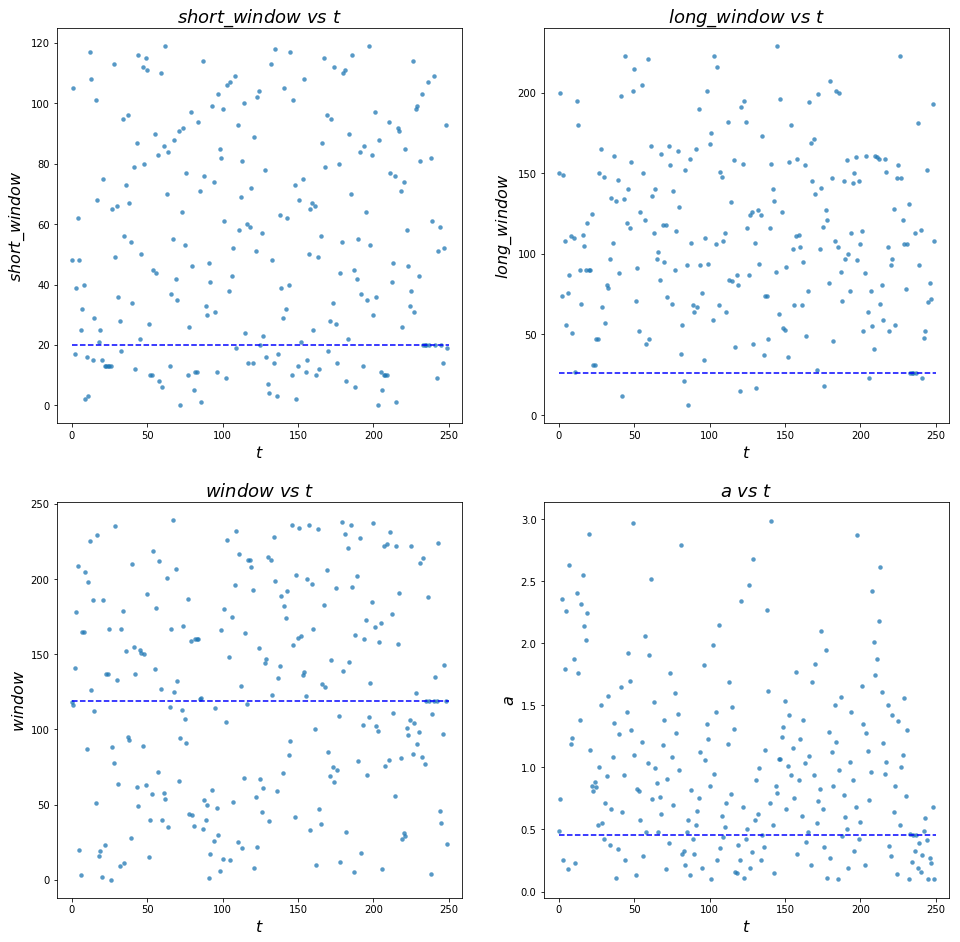

In [17]:
f, ax = plt.subplots(2, 2, figsize = (16, 16))
xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['short_window'] for t in trials.trials]
ax[0,0].set_xlim(xs[0]-10, xs[-1]+10)
ax[0,0].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[0,0].set_title('$short\_window$ $vs$ $t$ ', fontsize=18)
ax[0,0].set_xlabel('$t$', fontsize=16)
ax[0,0].set_ylabel('$short\_window$', fontsize=16)
ax[0,0].hlines(best['short_window'], 0, 250,color='blue',linestyle="--")

xs = [t['tid'] for t in trials.trials]
ys = [[t['misc']['vals']['delta_window'][0]+ t['misc']['vals']['short_window'][0]] for t in trials.trials]
ax[0,1].set_xlim(xs[0]-10, xs[-1]+10)
ax[0,1].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[0,1].set_title('$long\_window$ $vs$ $t$ ', fontsize=18)
ax[0,1].set_xlabel('$t$', fontsize=16)
ax[0,1].set_ylabel('$long\_window$', fontsize=16)
ax[0,1].hlines(best['delta_window'] + best['short_window'], 0, 250,color='blue',linestyle="--")

xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['window'] for t in trials.trials]
ax[1,0].set_xlim(xs[0]-10, xs[-1]+10)
ax[1,0].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[1,0].set_title('$window$ $vs$ $t$ ', fontsize=18)
ax[1,0].set_xlabel('$t$', fontsize=16)
ax[1,0].set_ylabel('$window$', fontsize=16)
ax[1,0].hlines(best['window'], 0, 250,color='blue',linestyle="--")

xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['a'] for t in trials.trials]
ax[1,1].set_xlim(xs[0]-10, xs[-1]+10)
ax[1,1].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[1,1].set_title('$a$ $vs$ $t$ ', fontsize=18)
ax[1,1].set_xlabel('$t$', fontsize=16)
ax[1,1].set_ylabel('$a$', fontsize=16)
ax[1,1].hlines(best['a'], 0, 250,color='blue',linestyle="--")

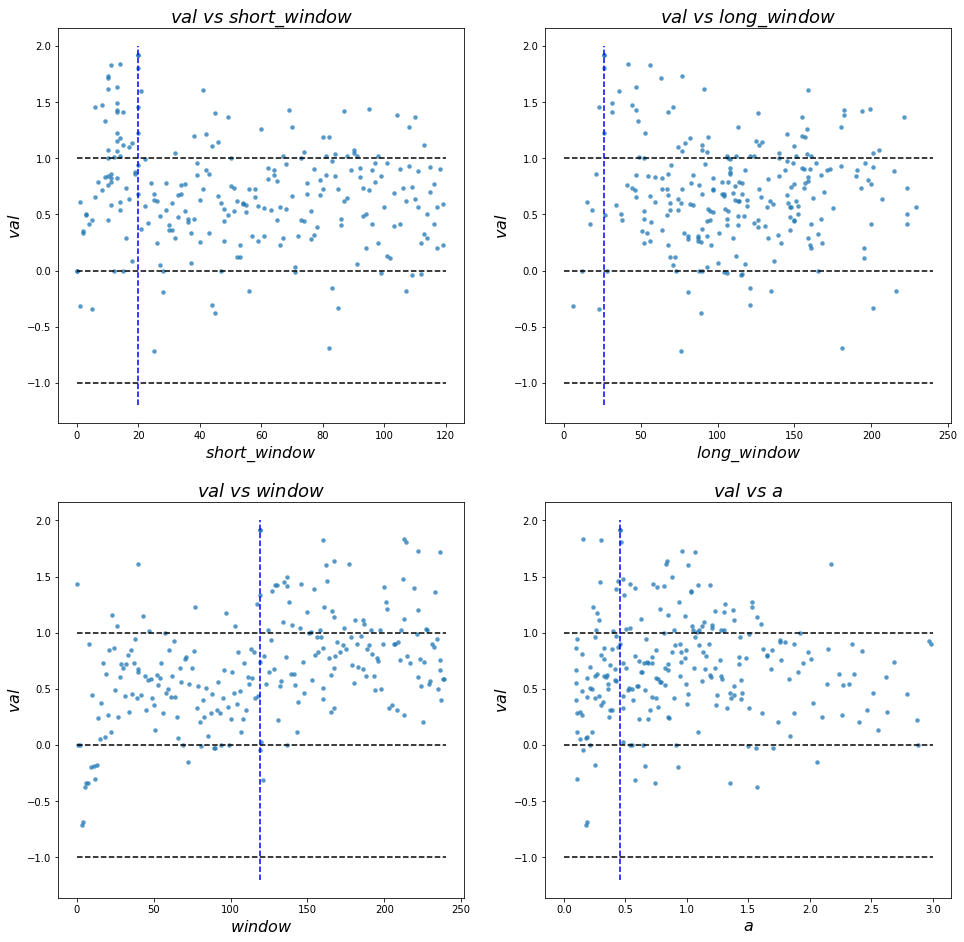

In [18]:
f, ax = plt.subplots(2,2, figsize = (16, 16))
xs = [t['misc']['vals']['short_window'] for t in trials.trials]
ys = [-1 * t['result']['loss'] for t in trials.trials]
ax[0,0].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[0,0].set_title('$val$ $vs$ $short\_window$ ', fontsize=18)
ax[0,0].set_xlabel('$short\_window$', fontsize=16)
ax[0,0].set_ylabel('$val$', fontsize=16)
ax[0,0].hlines(0, 0, 120, color='black',linestyle="--")
ax[0,0].hlines(-1, 0, 120, color='black',linestyle="--")
ax[0,0].hlines(1, 0, 120, color='black',linestyle="--")
ax[0,0].vlines(best['short_window'], -1.2, 2, color='blue',linestyle="--")

xs = [[t['misc']['vals']['delta_window'][0]+ t['misc']['vals']['short_window'][0]] for t in trials.trials]
ys = [-1 * t['result']['loss'] for t in trials.trials]
ax[0,1].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[0,1].set_title('$val$ $vs$ $long\_window$ ', fontsize=18)
ax[0,1].set_xlabel('$long\_window$', fontsize=16)
ax[0,1].set_ylabel('$val$', fontsize=16)
ax[0,1].hlines(0, 0, 240,color='black',linestyle="--")
ax[0,1].hlines(-1, 0, 240, color='black',linestyle="--")
ax[0,1].hlines(1, 0, 240,color='black',linestyle="--")
ax[0,1].vlines(best['delta_window'] + best['short_window'], -1.2, 2, color='blue',linestyle="--")

xs = [t['misc']['vals']['window'] for t in trials.trials]
ys = [-1 * t['result']['loss'] for t in trials.trials]
ax[1,0].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[1,0].set_title('$val$ $vs$ $window$ ', fontsize=18)
ax[1,0].set_xlabel('$window$', fontsize=16)
ax[1,0].set_ylabel('$val$', fontsize=16)
ax[1,0].hlines(0, 0, 240,color='black',linestyle="--")
ax[1,0].hlines(-1, 0, 240, color='black',linestyle="--")
ax[1,0].hlines(1, 0, 240,color='black',linestyle="--")
ax[1,0].vlines(best['window'], -1.2, 2, color='blue',linestyle="--")

xs = [t['misc']['vals']['a'] for t in trials.trials]
ys = [-1 * t['result']['loss'] for t in trials.trials]
ax[1,1].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[1,1].set_title('$val$ $vs$ $a$ ', fontsize=18)
ax[1,1].set_xlabel('$a$', fontsize=16)
ax[1,1].set_ylabel('$val$', fontsize=16)
ax[1,1].hlines(0, 0, 3,color='black',linestyle="--")
ax[1,1].hlines(-1, 0, 3, color='black',linestyle="--")
ax[1,1].hlines(1, 0, 3,color='black',linestyle="--")
ax[1,1].vlines(best['a'], -1.2, 2, color='blue',linestyle="--")